In [ ]:
import os
from tensorflow import keras
import tensorflow as tf
# tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()
from methods.config import *
from methods.clean_data import Data_Prep
from methods.nn import get_NN_results
from methods.var import get_VAR_results
from methods.model_results import get_model_details, get_best_model_name
from methods.data_methods import prepare_model_data
from methods.plot import plot_variables, plot_results, cluster_columns
from methods.residual_bootstrap import get_prediction_intervals
import shap

# Select Model

In [32]:
end_year = 2017 # Select from 2006, 2010, 2017 and 2019
variable = 'UNRATE' # Select from CPIAUCSL, GS5, RPI and UNRATE
output_steps = 1 # Select from 1, 3, 6, 12 and 24

# Vector Auto-Regression

In [33]:
data_prep = Data_Prep(DATA_PATH, TRANSFORM_PATH)
data_prep.transform_to_supervised_learning(NA_CUTOFF, TARGET_VARIABLES, output_steps = output_steps, start = f'{START_YEAR}-01-01', end = f'{end_year}-01-01')
var_dataset = data_prep.supervised_dataset
Var_results = get_VAR_results(var_dataset, test_steps = TEST_STEPS, val_steps = VAL_STEPS, output_steps = output_steps)

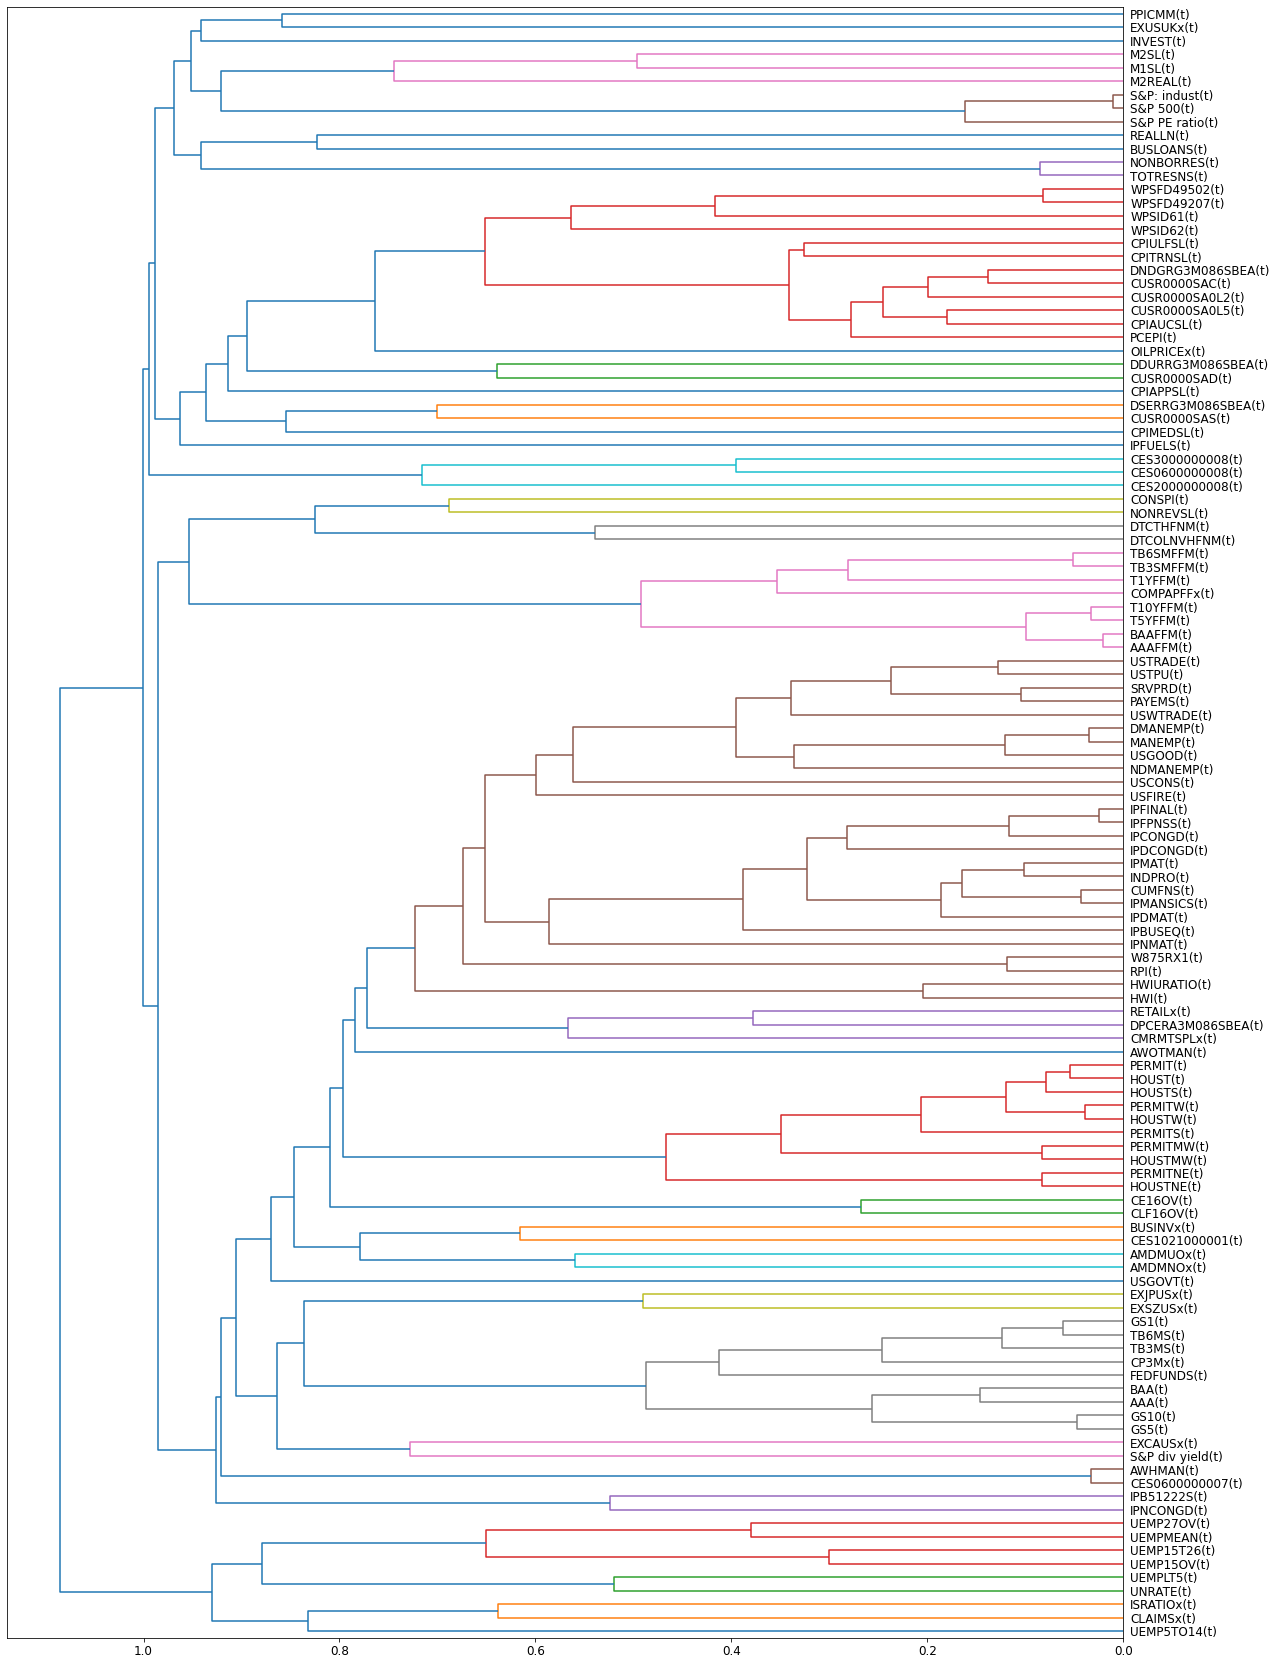

In [34]:
cluster_columns(var_dataset['transformed_data'][var_dataset['X_variables']], figsize=(20,30))

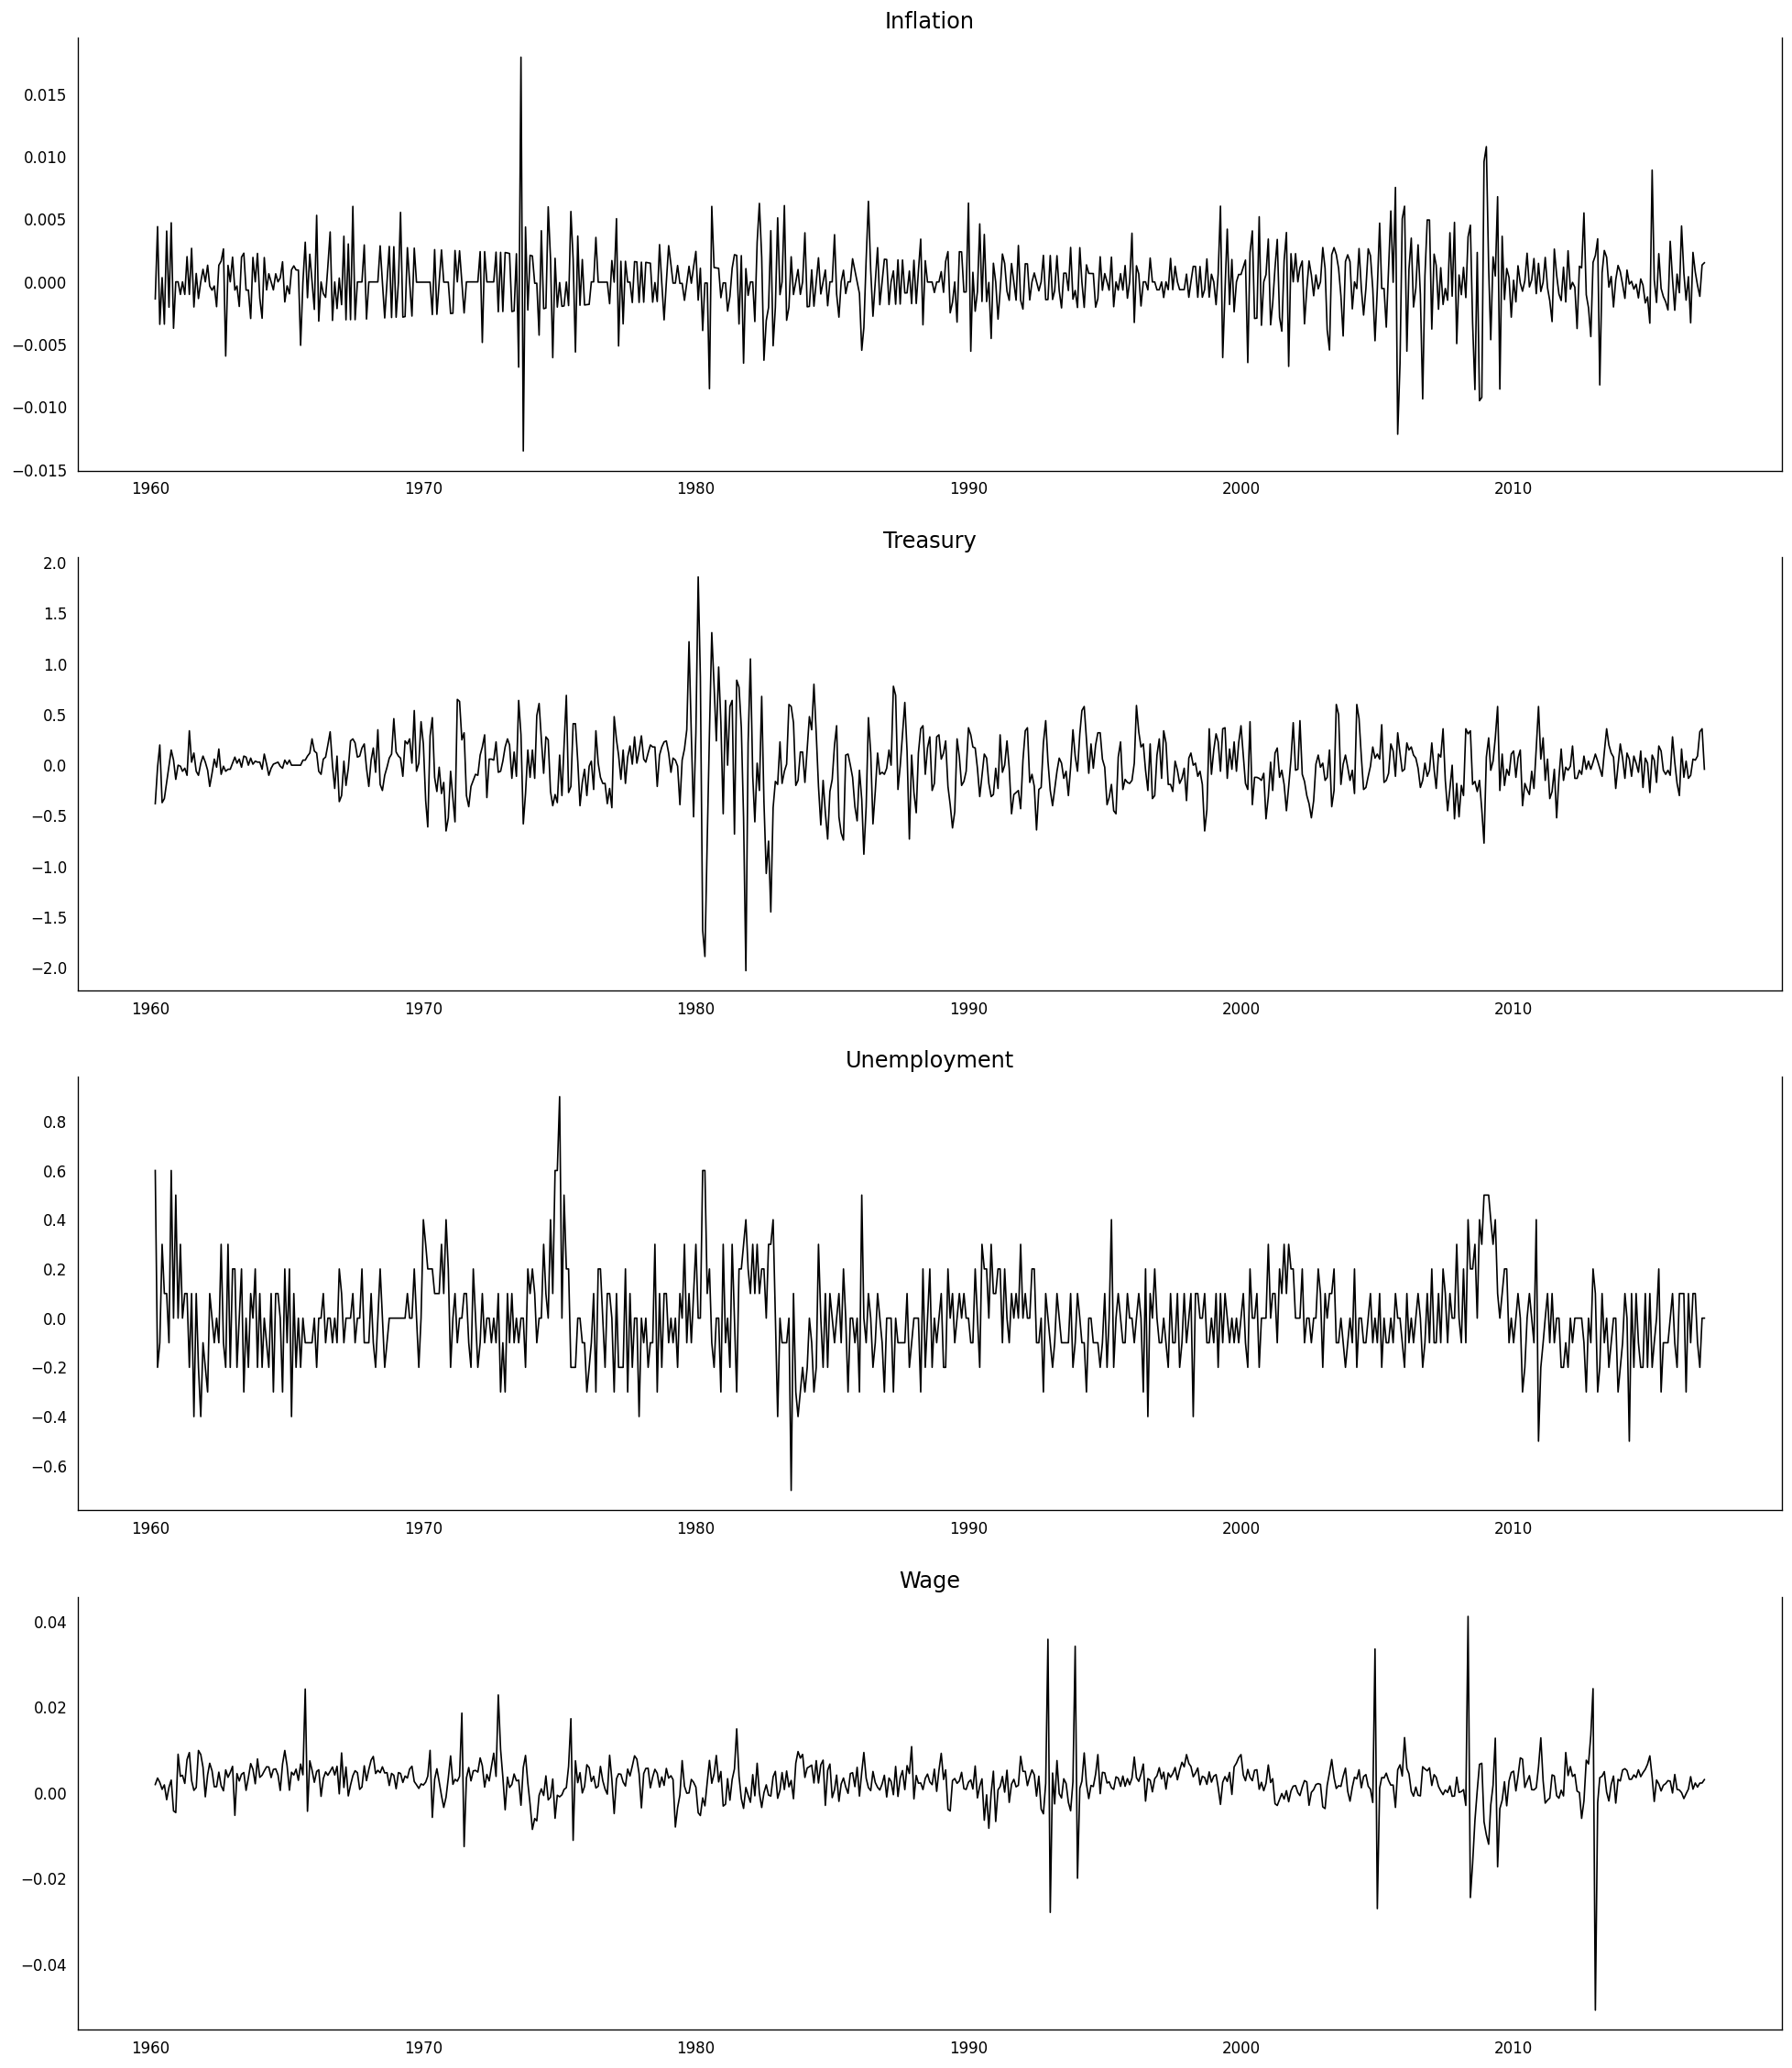

In [35]:
plot_variables(var_dataset)

# Neural Network

In [36]:
model_name = get_best_model_name(end_year, variable, output_steps)
model = keras.models.load_model(os.path.join(MODELS_PATH,model_name))

In [37]:
model_details = get_model_details(end_year, variable, output_steps)
look_back_steps = int(model_details['look_back_years']*12)
number_of_pca = model_details['number_of_pca']

In [38]:
look_back_steps

12

In [39]:
number_of_pca

0

In [40]:
model_details['model_parameters']

{'learning_rate': 0.001,
 'CNN_layers': 2,
 'LSTM_layers': 0,
 'Dense_layers': 1,
 'Dropout_prob': 0.2,
 'CNN_0_filters': 64,
 'LSTM_0_units': 128,
 'Dense_0_units': 128,
 'LSTM_1_units': 96,
 'Dense_1_units': 64,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0,
 'CNN_1_filters': 32}

In [41]:
data_prep.transform_to_supervised_learning(NA_CUTOFF, [variable], output_steps, start = f'{START_YEAR}-01-01', end = f'{end_year}-01-01')
dataset = data_prep.supervised_dataset
full_dataset = dataset['transformed_data']

In [42]:
data = prepare_model_data(window = full_dataset, X_variables = dataset['X_variables'], 
                Y_variables = dataset['Y_variables'], val_steps = VAL_STEPS, look_back = look_back_steps,
                test_steps = TEST_STEPS, remove_outlier = REMOVE_OUTLIER, number_of_pca = number_of_pca,
                target_variables = dataset['target_variables'])

data['train_X'] = data['train_X'][len(data['train_X'])%BATCH_SIZE:]
data['train_Y'] = data['train_Y'][len(data['train_Y'])%BATCH_SIZE:]

In [43]:
NN_results = get_NN_results(model, data, VAL_STEPS, TEST_STEPS, look_back_steps, dataset,  BATCH_SIZE, EPOCHS, executions = 5)

Fitting: 1


StagingError: in user code:

    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\engine\training.py:757 train_step
        self.trainable_variables)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\engine\training.py:2722 _minimize
        gradients = tape.gradient(loss, trainable_variables)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\eager\backprop.py:1073 gradient
        unconnected_gradients=unconnected_gradients)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\eager\imperative_grad.py:77 imperative_grad
        compat.as_str(unconnected_gradients.value))
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\eager\backprop.py:151 _gradient_function
        grad_fn = ops._gradient_registry.lookup(op_name)  # pylint: disable=protected-access
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\framework\registry.py:97 lookup
        "%s registry has no entry for: %s" % (self._name, name))

    LookupError: gradient registry has no entry for: shap_DivNoNan


# Compare Results

In [44]:
val_result = {k:v/Var_results['val']['error'][k] for k,v in NN_results['val']['error'].items()}
val_result['average'] = sum(val_result.values())/len(val_result.values())
val_result_raw = {k:v/Var_results['val']['error_raw'][k] for k,v in NN_results['val']['error_raw'].items()}
val_result

KeyError: 'RPI(t+2)'

In [45]:
test_result = {k:v/Var_results['test']['error'][k] for k,v in NN_results['test']['error'].items()}
test_result['average'] = sum(test_result.values())/len(test_result.values())
test_result_raw = {k:v/Var_results['test']['error_raw'][k] for k,v in NN_results['test']['error_raw'].items()}
test_result

KeyError: 'RPI(t+2)'

In [ ]:
intervals = get_prediction_intervals(NN_results)
plot_results(result = NN_results, period = 'test', target_variable = variable, show_interval = True, intervals = intervals)

In [ ]:
import shap

In [ ]:
# def get_shap_values(model, train_X, test_X):
#     explainer = shap.DeepExplainer(model, train_X)
#     return explainer.shap_values(test_X)[0].squeeze()

In [31]:
explainer = shap.DeepExplainer(NN_results.test_models[0], NN_results.data.train)
shap_values = explainer.shap_values(NN_results.data.test)

AttributeError: in user code:

    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\shap\explainers\_deep\deep_tf.py:239 grad_graph  *
        out = self.model(shap_rAnD)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:659 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\layers\recurrent_v2.py:1183 call
        runtime) = lstm_with_backend_selection(**normal_lstm_kwargs)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\keras\layers\recurrent_v2.py:1559 lstm_with_backend_selection
        function.register(defun_gpu_lstm, **params)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\eager\function.py:3241 register
        concrete_func.add_gradient_functions_to_graph()
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\eager\function.py:2063 add_gradient_functions_to_graph
        self._delayed_rewrite_functions.forward_backward())
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\eager\function.py:621 forward_backward
        forward, backward = self._construct_forward_backward(num_doutputs)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\eager\function.py:669 _construct_forward_backward
        func_graph=backwards_graph)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\framework\func_graph.py:986 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\eager\function.py:659 _backprop_function
        src_graph=self._func_graph)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\ops\gradients_util.py:669 _GradientsHelper
        lambda: grad_fn(op, *out_grads))
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\ops\gradients_util.py:336 _MaybeCompile
        return grad_fn()  # Exit early
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\tensorflow\python\ops\gradients_util.py:669 <lambda>
        lambda: grad_fn(op, *out_grads))
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\shap\explainers\_deep\deep_tf.py:367 custom_grad
        out = op_handlers[type_name](self, op, *grads) # we cut off the shap_ prefex before the lookup
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\shap\explainers\_deep\deep_tf.py:656 handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\shap\explainers\_deep\deep_tf.py:663 linearity_with_excluded_handler
        assert not explainer._variable_inputs(op)[i], str(i) + "th input to " + op.name + " cannot vary!"
    d:\Python Projects\Actuarial_NN_Forecasting\test_env\lib\site-packages\shap\explainers\_deep\deep_tf.py:216 _variable_inputs
        out[i] = t.name in self.between_tensors

    AttributeError: 'TFDeep' object has no attribute 'between_tensors'


In [ ]:
shap.initjs()

In [ ]:
feature_names = [i for i in range(12)]

In [ ]:
shap.summary_plot(shap_values[0].squeeze(), plot_type = 'bar', feature_names = feature_names)